# Lab11: Income Dataset SVM and Logistic Regression

#### Author: Dianna Hummel

In [1]:
# Import the needed libraries
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest,chi2,f_classif
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

##### Step A

In [2]:
cols = ['id','age','sex','race','edu','marstat','relation','workclass', 'hrswk','inc']
inc_data = pd.read_csv("inc_data.csv", header = None, names = cols, index_col = 'id')
inc_data.head()

,age,sex,race,edu,marstat,relation,workclass,hrswk,inc
id,,,,,,,,,
0,39,M,White,13,NevMarr,NoFamily,Gov,40,<=50K
1,50,M,White,13,Married,Husband,Self,13,<=50K
2,38,M,White,9,NotMarr,NoFamily,Priv,40,<=50K
3,53,M,NonWh,7,Married,Husband,Priv,40,<=50K
4,28,F,NonWh,13,Married,Wife,Priv,40,<=50K


In [3]:
inc_data.dtypes

age           int64
sex          object
race         object
edu           int64
marstat      object
relation     object
workclass    object
hrswk         int64
inc          object
dtype: object

In [4]:
inc_data.shape

(48842, 9)

##### Step B

In [5]:
inc_data = inc_data.dropna(axis = 1, how = 'any')
inc_data.isnull().sum()

age          0
sex          0
race         0
edu          0
marstat      0
relation     0
workclass    0
hrswk        0
inc          0
dtype: int64

In [6]:
cols = ['workclass','marstat','relation','race','sex','inc']
for col in cols:
    inc_data[col] = inc_data[col].str.strip()

##### Step C

In [7]:
inc_data['sex'].value_counts()

M    32650
F    16192
Name: sex, dtype: int64

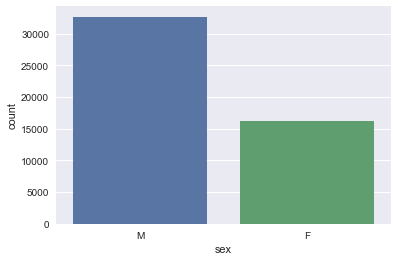

In [8]:
sns.countplot(x = 'sex', data = inc_data)

In [9]:
pd.pivot_table (inc_data, values='age', index=['sex'],
 columns='inc', margins = True, margins_name = 'total',
 aggfunc=lambda x: (len(x) / inc_data.shape[0])*100)

inc,<=50K,>50K,total
sex,,,
F,29.529913,3.621883,33.151796
M,46.541911,20.306294,66.848204
total,76.071823,23.928177,100.000000


In [10]:
inc_data['race'].value_counts()

White    41762
NonWh     7080
Name: race, dtype: int64

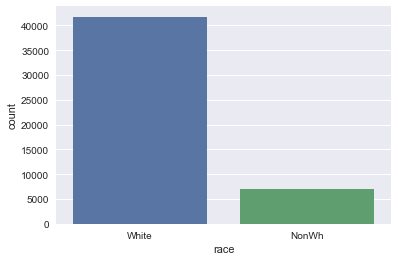

In [11]:
sns.countplot(x = 'race', data = inc_data)

In [12]:
pd.pivot_table (inc_data, values='age', index=['race'],
 columns='inc', margins = True, margins_name = 'total',
 aggfunc=lambda x: (len(x) / inc_data.shape[0])*100)

inc,<=50K,>50K,total
race,,,
NonWh,12.284509,2.211212,14.495721
White,63.787314,21.716965,85.504279
total,76.071823,23.928177,100.000000


In [13]:
inc_data['marstat'].value_counts()

Married    22416
NevMarr    16117
NotMarr    10309
Name: marstat, dtype: int64

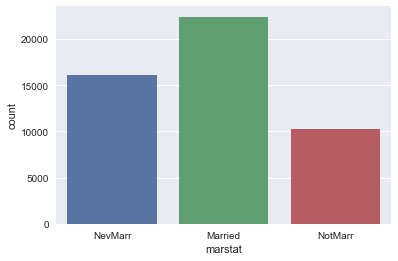

In [14]:
sns.countplot(x = 'marstat', data = inc_data)

In [15]:
pd.pivot_table (inc_data, values='age', index=['marstat'],
 columns='inc', margins = True, margins_name = 'total',
 aggfunc=lambda x: (len(x) / inc_data.shape[0])*100)

inc,<=50K,>50K,total
marstat,,,
Married,25.424839,20.470087,45.894926
NevMarr,31.497482,1.500758,32.998239
NotMarr,19.149502,1.957332,21.106834
total,76.071823,23.928177,100.000000


In [16]:
inc_data['relation'].value_counts()

Husband     19716
NoFamily    12583
Child        7581
OtherRel     6631
Wife         2331
Name: relation, dtype: int64

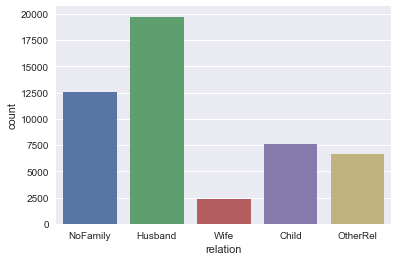

In [17]:
sns.countplot(x = 'relation', data = inc_data)

In [18]:
pd.pivot_table (inc_data, values='age', index=['relation'],
 columns='inc', margins = True, margins_name = 'total',
 aggfunc=lambda x: (len(x) / inc_data.shape[0])*100)

inc,<=50K,>50K,total
relation,,,
Child,15.294214,0.227263,15.521477
Husband,22.255436,18.111461,40.366897
NoFamily,23.150158,2.612506,25.762663
OtherRel,12.837312,0.739118,13.576430
Wife,2.534704,2.237828,4.772532
total,76.071823,23.928177,100.000000


In [19]:
inc_data['workclass'].value_counts()

Priv    36705
Gov      6549
Self     5588
Name: workclass, dtype: int64

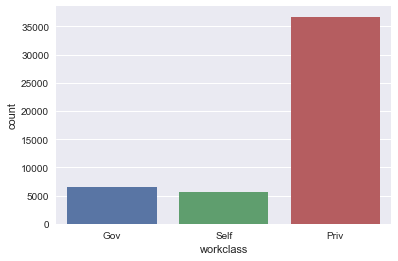

In [20]:
sns.countplot(x = 'workclass', data = inc_data)

In [21]:
pd.pivot_table (inc_data, values='age', index=['workclass'],
 columns='inc', margins = True, margins_name = 'total',
 aggfunc=lambda x: (len(x) / inc_data.shape[0])*100)

inc,<=50K,>50K,total
workclass,,,
Gov,9.276852,4.131690,13.408542
Priv,59.483641,15.666844,75.150485
Self,7.311330,4.129643,11.440973
total,76.071823,23.928177,100.000000


In [22]:
inc_data['inc'].value_counts()

<=50K    37155
>50K     11687
Name: inc, dtype: int64

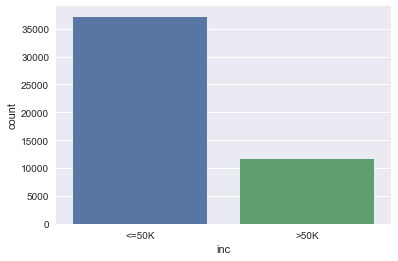

In [23]:
sns.countplot (x = 'inc', data = inc_data)

##### Step D

In [24]:
inc_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,48842.0,38.643585,13.710510,17.0,28.0,37.0,48.0,90.0
edu,48842.0,10.078089,2.570973,1.0,9.0,10.0,12.0,16.0
hrswk,48842.0,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0


In [25]:
inc_data['inc'].value_counts()[0]

37155

In [26]:
inc_data['inc'].value_counts()[1]


11687

In [27]:
age = pd.cut(inc_data['age'],[17, 33, 34, 64, 85, 90])
age_counts = pd.pivot_table (inc_data, values='age', index=[age], columns='inc', aggfunc= lambda x: len(x))
age_counts

inc,<=50K,>50K
age,,
"(17, 33]",17257,1854
"(33, 34]",949,354
"(34, 64]",16694,9052
"(64, 85]",1607,413
"(85, 90]",53,14


In [28]:
perc_low_50K = age_counts['<=50K'] / inc_data['inc'].value_counts()[0]
perc_low_50K

age
(17, 33]    0.464460
(33, 34]    0.025542
(34, 64]    0.449307
(64, 85]    0.043251
(85, 90]    0.001426
Name: <=50K, dtype: float64

In [29]:
perc_hi_50K = age_counts['>50K'] / inc_data['inc'].value_counts()[1]
perc_hi_50K

age
(17, 33]    0.158638
(33, 34]    0.030290
(34, 64]    0.774536
(64, 85]    0.035338
(85, 90]    0.001198
Name: >50K, dtype: float64

In [30]:
age_counts = pd.concat([age_counts, perc_low_50K, perc_hi_50K], axis = 1)
age_counts

,<=50K,>50K,<=50K,>50K
age,,,,
"(17, 33]",17257,1854,0.464460,0.158638
"(33, 34]",949,354,0.025542,0.030290
"(34, 64]",16694,9052,0.449307,0.774536
"(64, 85]",1607,413,0.043251,0.035338
"(85, 90]",53,14,0.001426,0.001198


In [31]:
edu = pd.cut(inc_data['edu'],[1,11,16])
edu_counts = pd.pivot_table (inc_data, values='edu', index=[edu], columns='inc', aggfunc= lambda x: len(x))
edu_counts

inc,<=50K,>50K
edu,,
"(1, 11]",29595,5453
"(11, 16]",7478,6233


In [32]:
perc_low_50K = edu_counts['<=50K'] / inc_data['inc'].value_counts()[0]
perc_hi_50K = edu_counts['>50K'] / inc_data['inc'].value_counts()[1]
edu_counts = pd.concat([edu_counts, perc_low_50K, perc_hi_50K], axis = 1)
edu_counts

,<=50K,>50K,<=50K,>50K
edu,,,,
"(1, 11]",29595,5453,0.796528,0.466587
"(11, 16]",7478,6233,0.201265,0.533328


In [33]:
hrswk = pd.cut(inc_data['hrswk'],[1,40,99])
hrswk_counts = pd.pivot_table (inc_data, values='hrswk', index=[hrswk], columns='inc', aggfunc= lambda x: len(x))
hrswk_counts

inc,<=50K,>50K
hrswk,,
"(1, 40]",28521,5942
"(40, 99]",8610,5742


In [34]:
perc_low_50K = hrswk_counts['<=50K'] / inc_data['inc'].value_counts()[0]
perc_hi_50K = hrswk_counts['>50K'] / inc_data['inc'].value_counts()[1]
hrswk_counts = pd.concat([hrswk_counts, perc_low_50K, perc_hi_50K], axis = 1)
hrswk_counts

,<=50K,>50K,<=50K,>50K
hrswk,,,,
"(1, 40]",28521,5942,0.767622,0.508428
"(40, 99]",8610,5742,0.231732,0.491315


##### Step E

In [35]:
inc_data.loc[(inc_data.inc == '<=50K'), 'inc'] = 0
inc_data.loc[(inc_data.inc == '>50K'), 'inc'] = 1
inc_data.inc = inc_data.inc.astype(int)
inc_data['inc'].value_counts()

0    37155
1    11687
Name: inc, dtype: int64

In [36]:
inc_data.loc[(inc_data.sex == 'F'), 'sex'] = 0
inc_data.loc[(inc_data.sex == 'M'), 'sex'] = 1
inc_data.sex = inc_data.sex.astype(int)
inc_data['sex'].value_counts()

1    32650
0    16192
Name: sex, dtype: int64

In [37]:
inc_data.loc[(inc_data.race == 'NonWh'), 'race'] = 0
inc_data.loc[(inc_data.race == 'White'), 'race'] = 1
inc_data.race = inc_data.race.astype(int)
inc_data['race'].value_counts()

1    41762
0     7080
Name: race, dtype: int64

In [38]:
inc_data.loc[(inc_data.edu <= 11), 'edu'] = 0
inc_data.loc[(inc_data.edu > 11), 'edu'] = 1
inc_data['edu'].value_counts()

0    35131
1    13711
Name: edu, dtype: int64

In [39]:
inc_data.loc[(inc_data.hrswk <= 40), 'hrswk'] = 0
inc_data.loc[(inc_data.hrswk > 40), 'hrswk'] = 1

inc_data['hrswk'].value_counts()

0    34490
1    14352
Name: hrswk, dtype: int64

In [40]:
inc_data.age = inc_data.age.astype(str)
inc_data.loc[(inc_data.age > '65'), 'age'] = 'Old'
inc_data.loc[(inc_data.age <= '33'), 'age'] = 'Young'
inc_data.loc[(inc_data.age < 'Old'), 'age'] = 'Mid'
inc_data['age'].value_counts()

Mid      27333
Young    19706
Old       1803
Name: age, dtype: int64

In [41]:
age_dum = pd.get_dummies (inc_data['age'], prefix = 'AGE')
ms_dum = pd.get_dummies (inc_data['marstat'], prefix = 'MS')
rel_dum = pd.get_dummies (inc_data['relation'], prefix = 'REL')
wc_dum = pd.get_dummies (inc_data['workclass'], prefix = 'WC')
inc_dum = pd.concat([age_dum, ms_dum, rel_dum, wc_dum], axis=1)
inc_dum.head(10).T


id,0,1,2,3,4,5,6,7,8,9
AGE_Mid,1,1,1,1,0,1,1,1,0,1
AGE_Old,0,0,0,0,0,0,0,0,0,0
AGE_Young,0,0,0,0,1,0,0,0,1,0
MS_Married,0,1,0,1,1,1,0,1,0,1
MS_NevMarr,1,0,0,0,0,0,0,0,1,0
MS_NotMarr,0,0,1,0,0,0,1,0,0,0
REL_Child,0,0,0,0,0,0,0,0,0,0
REL_Husband,0,1,0,1,0,0,0,1,0,1
REL_NoFamily,1,0,1,0,0,0,1,0,1,0
REL_OtherRel,0,0,0,0,0,0,0,0,0,0


In [42]:
inc_dum = inc_dum.drop(['AGE_Old', 'MS_NevMarr', 'REL_OtherRel', 'WC_Self'], axis = 1)
inc_dataD = inc_data[['inc', 'sex', 'edu', 'hrswk']]
inc_data = pd.concat([inc_dataD, inc_dum], axis=1)
inc_data.head(10).T

id,0,1,2,3,4,5,6,7,8,9
inc,0,0,0,0,0,0,0,1,1,1
sex,1,1,1,1,0,0,0,1,0,1
edu,1,1,0,0,1,1,0,0,1,1
hrswk,0,0,0,0,0,0,0,1,1,0
AGE_Mid,1,1,1,1,0,1,1,1,0,1
AGE_Young,0,0,0,0,1,0,0,0,1,0
MS_Married,0,1,0,1,1,1,0,1,0,1
MS_NotMarr,0,0,1,0,0,0,1,0,0,0
REL_Child,0,0,0,0,0,0,0,0,0,0
REL_Husband,0,1,0,1,0,0,0,1,0,1


##### Step F

In [43]:
inc_data.corr()
inc_corr = inc_data.corr()
columns = ['inc', 'sex', 'edu', 'hrswk', 'AGE_Mid', 'AGE_Young',
           'MS_Married', 'MS_NotMarr', 'REL_Child', 'REL_Husband',
           'REL_NoFamily', 'REL_Wife', 'WC_Gov', 'WC_Priv']
grps = ['NegStrong', 'NegMedium', 'Weak','PosMedium', 'PosStrong']
for col in columns:
    inc_corr[col] = pd.cut(inc_corr[col],(-1, -0.6, -0.2, 0.2, 0.6, 1), labels=grps)
inc_corr 

,inc,sex,edu,hrswk,AGE_Mid,AGE_Young,MS_Married,MS_NotMarr,REL_Child,REL_Husband,REL_NoFamily,REL_Wife,WC_Gov,WC_Priv
inc,PosStrong,PosMedium,PosMedium,PosMedium,PosMedium,NegMedium,PosMedium,Weak,NegMedium,PosMedium,Weak,Weak,Weak,Weak
sex,PosMedium,PosStrong,Weak,PosMedium,Weak,Weak,PosMedium,NegMedium,Weak,PosMedium,Weak,NegMedium,Weak,Weak
edu,PosMedium,Weak,PosStrong,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak
hrswk,PosMedium,PosMedium,Weak,PosStrong,Weak,Weak,Weak,Weak,Weak,PosMedium,Weak,Weak,Weak,Weak
AGE_Mid,PosMedium,Weak,Weak,Weak,PosStrong,NegStrong,PosMedium,Weak,NegMedium,PosMedium,Weak,Weak,Weak,Weak
AGE_Young,NegMedium,Weak,Weak,Weak,NegStrong,PosStrong,NegMedium,NegMedium,PosMedium,NegMedium,Weak,Weak,Weak,Weak
MS_Married,PosMedium,PosMedium,Weak,Weak,PosMedium,NegMedium,PosStrong,NegMedium,NegMedium,PosStrong,NegMedium,PosMedium,Weak,Weak
MS_NotMarr,Weak,NegMedium,Weak,Weak,Weak,NegMedium,NegMedium,PosStrong,Weak,NegMedium,PosMedium,Weak,Weak,Weak
REL_Child,NegMedium,Weak,Weak,Weak,NegMedium,PosMedium,NegMedium,Weak,PosStrong,NegMedium,NegMedium,Weak,Weak,Weak
REL_Husband,PosMedium,PosMedium,Weak,PosMedium,PosMedium,NegMedium,PosStrong,NegMedium,NegMedium,PosStrong,NegMedium,Weak,Weak,Weak


##### Step G

In [44]:
Y = inc_data [['inc']]
X = inc_data.drop(['inc'], axis=1)
Y = Y.values
Y = Y.ravel()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,random_state=33,test_size=0.2)
pd.Series(Y_test).value_counts()

0    7486
1    2283
dtype: int64

In [45]:
hi_sc = 0
for p in ['l1', 'l2']:
    for c in [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10]:
        lr = LogisticRegression (C=c, penalty = p)
        lr.fit (X_train,Y_train)
        ts_sc = lr.score (X_test, Y_test)
        if ts_sc > hi_sc:
            hi_sc = ts_sc
            hi_c = c
            hi_p = p
print ("Best Test score and params:", hi_sc, hi_c, hi_p)

Best Test score and params: 0.822806837957 0.05 l2


Accuracy on test set: 0.8228
[[7064  422]
 [1309  974]]


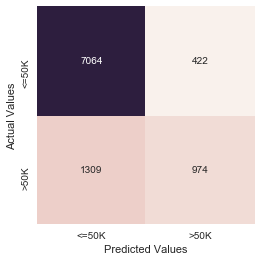

In [46]:
lr = LogisticRegression (C=0.05, penalty = 'l2')
lr.fit (X_train, Y_train)
Y_pred = lr.predict(X_test)
print('Accuracy on test set: {:.4f}'.format(lr.score(X_test, Y_test)))
mat = confusion_matrix (Y_test, Y_pred)
print(mat)
sns.heatmap(mat, square=True, annot=True, cbar=False, fmt="d", xticklabels = ['<=50K','>50K'],yticklabels= ['<=50K','>50K'])
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

True Positives =7064
True Negatives =974
False Positives =1309
False Negatives =422
Sensitivity: True Positive Rate =.9436
Specificity: True Negative Rate =.4266
Accuracy = .8228

In [47]:
lr.coef_

array([[ 0.4387656 ,  1.47855723,  0.69153983,  0.27820952, -0.72175852,
         1.60234653,  0.0880085 , -0.84705363,  0.4143434 ,  0.16254066,
         1.14209405,  0.12083965, -0.03768126]])

In [48]:
lr.intercept_

array([-3.49937744])

Log (P/1-P) = -3.50 + 0.439*SEX + 1.48*EDU + 0.692*HRSWK +
0.278*AGE_MID – 0.722*AGE_YOUNG +
1.60*MS_MARRIED + 0.0880*MS_NOTMARR –
0.847*REL_CHILD + 0.414*REL_HUSB +
0.163*REL_NOFAM + 1.14*REL_WIFE +
0.121*WC_GOV - 0.0377*WC_PRIV

##### Step H

In [49]:
Y = inc_data [['inc']]
X = inc_data.drop (['inc'], axis=1)
Y = Y.values
Y = Y.ravel()
ks = [6, 7, 8, 9, 10, 11, 12, 13]
cs = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
pen = ['l1','l2']
kbest = SelectKBest (chi2)
pipe = Pipeline([('kbest', kbest),('lr', LogisticRegression())])
grid_search = GridSearchCV (pipe,{'kbest__k': ks, 'lr__C': cs,
 'lr__penalty': pen}, cv=5)
grid_search.fit (X,Y)
grid_search.best_score_

0.82195651283731219

In [50]:
params = grid_search.cv_results_['params']
rank = grid_search.cv_results_['rank_test_score']
for i in range (len(rank)):
    if rank[i] == 1:
        print (params[i]) 

{'kbest__k': 6, 'lr__C': 0.01, 'lr__penalty': 'l1'}
{'kbest__k': 7, 'lr__C': 0.01, 'lr__penalty': 'l1'}
{'kbest__k': 8, 'lr__C': 0.01, 'lr__penalty': 'l1'}
{'kbest__k': 9, 'lr__C': 0.01, 'lr__penalty': 'l1'}
{'kbest__k': 10, 'lr__C': 0.01, 'lr__penalty': 'l1'}


In [51]:
kbest2 = SelectKBest(chi2, k=10)
kbest2.fit(X,Y)
X_best = kbest2.transform(X)
Xv = X.values
col_list = []
for c in range (len (Xv.T)):
    for j in range (len (X_best.T)):
        found = True
        for x in range(20):
            if Xv[x][c] != X_best[x][j]:
                found = False
        if found:
            col_list.append(c)
col_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [52]:
Y = inc_data [['inc']]
X = inc_data.drop(['inc','REL_Wife','WC_Gov','WC_Priv'], axis=1)
Y = Y.values
Y = Y.ravel()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
 random_state=33,test_size=0.2)
lr = LogisticRegression (C=0.01, penalty = 'l1')
lr.fit (X_train, Y_train)
print ('Accuracy: {:.4f}'.format(lr.score (X_test, Y_test)))

Accuracy: 0.8226


In [53]:
lr.intercept_

array([-2.87354662])

In [54]:
lr.coef_

array([[ 0.        ,  1.42288704,  0.62640511,  0.09318854, -0.84481309,
         2.03344078,  0.        , -0.45449225,  0.        ,  0.        ]])

Log (P/1-P) = -2.87 + 1.42*EDU + 0.626*HRSWK +
 0.0933*AGE_MID – 0.845*AGE_YOUNG +
 2.03*MS_MARRIED – 0.454*REL_CHILD 

[[7106  380]
 [1353  930]]


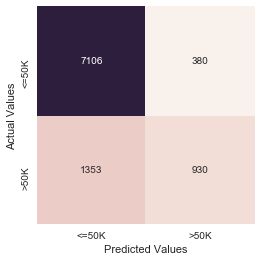

In [55]:
Y_pred = lr.predict(X_test)
mat = confusion_matrix (Y_test, Y_pred)
print (mat)
sns.heatmap(mat, square=True, annot=True, cbar=False,
 fmt="d", xticklabels = ['<=50K','>50K'],
 yticklabels = ['<=50K','>50K'])
plt.xlabel ('Predicted Values')
plt.ylabel ('Actual Values')

##### Step I

In [56]:
Y = inc_data [['inc']]
X = inc_data.drop(['inc'], axis=1)
Y = Y.values
Y = Y.ravel()
X_train, X_test, Y_train, Y_test = train_test_split (X, Y,
 random_state=33,test_size=0.2)
cs = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
pen = ['l1','l2']
pca = PCA()
lr = LogisticRegression()
pipe = Pipeline([('pca', pca), ('lr', lr)])
pca.fit(X)
n_comps = [6, 7, 8, 9, 10, 11, 12, 13]
grid_search = GridSearchCV(pipe, {'pca__n_components': n_comps,
 'lr__C': cs, 'lr__penalty': pen}, cv=5)
grid_search.fit(X,Y)
grid_search.best_score_

0.82226362556815857

In [57]:
params = grid_search.cv_results_['params']
rank = grid_search.cv_results_['rank_test_score']
for i in range (len(rank)):
    if rank[i] == 1:
        print (params[i])

{'lr__C': 0.005, 'lr__penalty': 'l2', 'pca__n_components': 11}


In [58]:
Y = inc_data [['inc']]
X = inc_data.drop(['inc'], axis=1)
Y = Y.values
Y = Y.ravel()
pca = PCA (n_components=11)
pca.fit (X)
X_11D = pca.transform (X)
X_train, X_test, Y_train, Y_test = train_test_split(X_11D, Y,
 random_state=33,test_size=0.2)
lr = LogisticRegression(C=0.005, penalty = 'l2')
lr.fit (X_train, Y_train)
print('Accuracy: {:.4f}'.format(lr.score(X_test, Y_test)))


Accuracy: 0.8231


[[7087  399]
 [1329  954]]


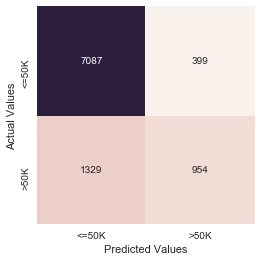

In [59]:
Y_pred = lr.predict(X_test)
mat = confusion_matrix (Y_test, Y_pred)
print (mat)
sns.heatmap(mat, square=True, annot=True, cbar=False,
 fmt="d", xticklabels = ['<=50K','>50K'],
 yticklabels = ['<=50K','>50K'])
plt.xlabel ('Predicted Values')
plt.ylabel ('Actual Values')

True Positives =7087
True Negatives =954
False Positives =399
False Negatives =1329
Sensitivity: True Positive Rate =.8421
Specificity: True Negative Rate =.7051
Accuracy =.8231


##### Step J

In [60]:
Y = inc_data [['inc']]
X = inc_data.drop (['inc'], axis=1)
Y = Y.values
Y = Y.ravel()
n_comps = [6, 7, 8, 9, 10, 11, 12, 13]
ks = [6, 7, 8, 9, 10, 11, 12, 13]
cs = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
pipe = Pipeline([('reduce_dim', PCA()), ('classify', LinearSVC())])
param_grid = [{'reduce_dim': [PCA()], 'reduce_dim__n_components': n_comps, 'classify__C': cs },
              {'reduce_dim': [SelectKBest (chi2)],'reduce_dim__k': ks, 'classify__C': cs }]
grid_search = GridSearchCV (pipe, param_grid=param_grid, cv=5)
grid_search.fit (X,Y)
grid_search.best_score_

0.82201793538348145

In [61]:
params = grid_search.cv_results_['params']
rank = grid_search.cv_results_['rank_test_score']
for i in range (len(rank)):
    if rank[i] == 1:
        print (params[i])

{'classify__C': 0.001, 'reduce_dim': PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 10}
{'classify__C': 0.05, 'reduce_dim': PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 8}
{'classify__C': 0.1, 'reduce_dim': PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 8}
{'classify__C': 0.5, 'reduce_dim': PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 8}
{'classify__C': 1, 'reduce_dim': PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 8}
{'classify__C': 5, 'reduce_dim': PCA(copy=True, iterated_power='auto', n_

Accuracy: 0.8228
[[7106  380]
 [1351  932]]


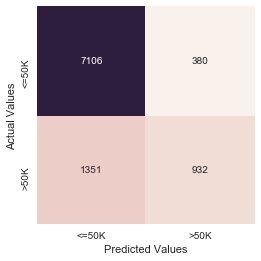

In [62]:
Y = inc_data [['inc']]
X = inc_data.drop(['inc'], axis=1)
Y = Y.values
Y = Y.ravel()
pca = PCA (n_components=10)
pca.fit (X)
X_10D = pca.transform (X)
X_train, X_test, Y_train, Y_test = train_test_split (X_10D, Y,
 random_state=33, test_size=0.2)
svm = LinearSVC (C=0.001)
svm.fit (X_train, Y_train)
print ('Accuracy: {:.4f}'.format (svm.score( X_test, Y_test)))

Y_pred = svm.predict(X_test)
mat = confusion_matrix (Y_test, Y_pred)
print (mat)
sns.heatmap(mat, square=True, annot=True, cbar=False,
 fmt="d", xticklabels = ['<=50K','>50K'],
 yticklabels = ['<=50K','>50K'])
plt.xlabel ('Predicted Values')
plt.ylabel ('Actual Values')

True Positives =7106
True Negatives =932
False Positives =380
False Negatives =1351
Sensitivity: True Positive Rate =
Specificity: True Negative Rate =
Accuracy =